From tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from methods import *
from utils import *

# Choice of Model to Attack
- LeNet5: MNIST
- Basic CNN: Fashion MNIST
- ResNet20: CIFAR-10
### Run **ONE** of the following 3 cells

In [2]:
from models.LeNet import *
target_mdl = LeNet("models/lenet_mnist_model.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader

In [3]:
from models.simple_FashionMNIST import *
target_mdl = simple_FashionMNIST("models/simple_FashionMNIST.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader

Running on cpu.
Model weights loaded successfully


In [4]:
from models.resNet import ResNet20
target_mdl = ResNet20()
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader

Using cache found in C:\Users\JIC/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


In [5]:
#def test(target_model, device, epsilon,num_fw_iter, num_test = 1000, method='fw', early_stopping = None, fw_stepsize_rule = 1, gap_FW_tol = 0.05, targeted = False):
target_model = target_mdl
fw_stepsize_rule = 'decay'
targeted = True
epsilon = 0.001
method = 'fw_away'
test_idx = 8#10


testloader = target_model.testloader
model = target_model.model

# Accuracy counter
correct = 0
adv_examples = []
hist = []
ex_num = 0
# Loop over all examples in test set
x0, target = None, None
for idx, (x0_cur, target_cur) in enumerate(testloader):
    if idx == test_idx:
        x0, target = x0_cur, target_cur
        break

## init the attack

x_t = x0.detach().clone().to(device)  # Clone and move to device
# Send the data and label to the device
x0, target = x0.to(device), target.to(device)
x0_denorm = target_model.denorm(x0)
if targeted:
    # select a random target for attack that is not the true target.
    adv_target = random.randint(0, target_model.num_classes - 2)
    adv_target = adv_target if adv_target < target else adv_target + 1
    criterion = AdversarialLoss(target_model.num_classes, specific_label=adv_target)
else:
    criterion = AdversarialLoss(target_model.num_classes)
lmo = LMO(epsilon, x0_denorm)
stepsize_method = stepsize(model, fw_stepsize_rule, x0_denorm, ls_criterion=criterion, ls_target=target)
attackStep = AttackStep(method, epsilon, x0_denorm, lmo, stepsize_method)
#x_t.requires_grad = True  #Set requires_grad attribute of tensor. Important for Attack
had_first_success = False
gap_FW = None
info = None

t=0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.20000000000000007, 0.16666666666666666, 0.2, 0.23333333333333336, 0.2]


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,gap_AS,awayCosts,step_type,...,alphas,L_inf_step,L_inf_alpha,step_alpha_diffFactor,drop_step,v_t_idx,l_inf,targeted_success,min_revisit_diff,drop_stepAS
0,0,1,0.841384,False,False,3,3,0.000000e+00,[-0.49849188327789307],FW,...,"[1, 0.0]",0.001,0.001,0.000000,FW,0,0.001,False,NaN,NaN
1,0,2,0.099144,False,False,3,3,-8.689912e-07,[-0.5352739095687866],FW,...,"[0.33333333333333337, 0.6666666666666666, 0.0]",0.001,0.001,0.025205,NaN,0,0.001,False,1.063989,NaN
2,0,3,0.067253,False,False,3,3,8.474052e-03,"[-0.42966723442077637, -0.4423799514770508]",FW,...,"[0.16666666666666669, 0.3333333333333333, 0.5]",0.001,0.001,0.018850,NaN,0,0.001,False,0.679993,NaN
3,0,4,0.029795,False,False,3,3,4.415188e-02,"[-0.38835763931274414, -0.4341888427734375, -0...",AS,...,"[0.39999999999999997, 0.6, 0.0]",0.001,0.001,0.048667,NaN,0,0.001,False,NaN,AS
4,0,5,0.027690,False,False,3,3,1.352914e-02,"[-0.43020033836364746, -0.45275235176086426]",FW,...,"[0.26666666666666666, 0.4, 0.3333333333333333,...",0.001,0.001,0.033952,NaN,0,0.001,False,0.483995,NaN
5,0,6,0.018552,False,False,3,3,1.358171e-02,"[-0.46587562561035156, -0.4843871593475342, -0...",FW,...,"[0.19047619047619047, 0.28571428571428575, 0.2...",0.001,0.001,0.039183,NaN,0,0.001,False,0.389996,NaN
6,0,7,0.016691,False,False,3,3,1.581710e-02,"[-0.5290684700012207, -0.5483148097991943, -0....",FW,...,"[0.14285714285714285, 0.2142857142857143, 0.17...",0.001,0.001,0.013605,NaN,0,0.001,False,0.349996,NaN
7,0,8,0.014492,False,False,3,3,2.103802e-02,"[-0.5032567977905273, -0.5272760391235352, -0....",AS,...,"[0.25000000000000006, 0.20833333333333331, 0.2...",0.001,0.001,-0.030667,NaN,0,0.001,False,NaN,AS
8,0,9,0.019517,False,False,3,3,6.564436e-03,"[-0.5569961071014404, -0.5630428791046143, -0....",FW,...,"[0.20000000000000007, 0.16666666666666666, 0.2...",0.001,0.001,0.025064,NaN,0,0.001,False,0.273997,NaN


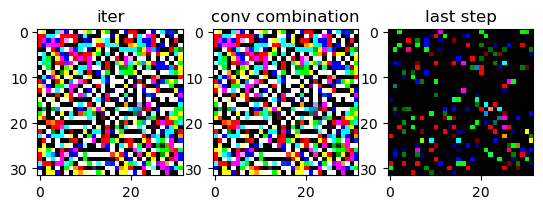

In [14]:
#for t in range(num_fw_iter):
# Step size calculation
if stepsize_method.strat == 'decay':
    stepsize_method.set_stepsize_decay(t)
x_t.requires_grad = True
# Forward pass the data through the model
output = model(x_t)
init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

# Calculate the loss
loss = criterion(output, target)
# Zero all existing gradients
model.zero_grad()
# Calculate gradients of model in backward pass
loss.backward()
x_t_grad = x_t.grad#.data
# Restore the data to its original scale
x_t_denorm = target_model.denorm(x_t)
# Call Attack
with torch.no_grad():
    perturbed_image, gap_FW, info = attackStep.step(x_t_denorm, x_t_grad)

# Reapply normalization
x_t = target_model.renorm(perturbed_image)#transforms.Normalize((0.1307,), (0.3081,))(perturbed_image).detach()
# Re-classify the perturbed image
x_t.requires_grad = False
output = model(x_t)
info['l_inf'] = torch.max(torch.abs(x0_denorm - perturbed_image)).item()
# Check for success
final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
if final_pred.item() == target.item():
    success = False
    first_success = False
    # if t == num_fw_iter - 1:
    #     correct += 1
    # Special case for saving 0 epsilon examples
    if epsilon == 0 and len(adv_examples) < 5:
        adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
else:
    first_success =  not had_first_success
    had_first_success = True
    success = True
    # Save some adv examples for visualization later
    if len(adv_examples) < 5:
        adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
hist_iter = {
    'example_idx':ex_num,
    'FW_iter': t + 1, # original example is 0
    'gap_FW': gap_FW if gap_FW is not None else None,
    'success': success,
    'first_success': first_success,
    'target': target.item(),
    'pred': final_pred.item(),
}
if targeted:
    info['targeted_success'] = (final_pred.item() == adv_target)
if info is not None:
    hist_iter.update(info) # some methods output dict containing info at each step
hist.append(hist_iter)

t = t+1
#print(len(attackStep.A_t), len(attackStep.S_t))
fig, axs = plt.subplots(1, 3)
axs[0].imshow((perturbed_image-x0_denorm).squeeze(0).permute(1, 2, 0).numpy() / epsilon)
axs[0].set_title('iter')
perturbed_image_alpha = sum([alpha * v for alpha, v in zip(attackStep.A_t, attackStep.S_t)])
axs[1].imshow(((perturbed_image_alpha-x0_denorm).squeeze(0).permute(1, 2, 0).numpy() / epsilon).clip(0,1))
axs[1].set_title('conv combination')
axs[2].imshow((attackStep.last_d).squeeze(0).permute(1, 2, 0).numpy() / epsilon)
axs[2].set_title('last step')
print(attackStep.A_t)
pd.DataFrame(hist)

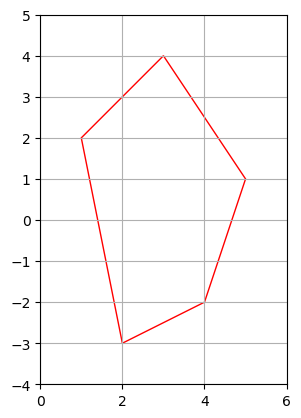

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Define the vertices of the polygon
vertices = [(1, 2), (3, 4), (5, 1), (4, -2), (2, -3)]

# Create a figure and axis
fig, ax = plt.subplots()

# Create the polygon
polygon = Polygon(vertices, closed=True, edgecolor='r', facecolor='none')

# Add the polygon to the plot
ax.add_patch(polygon)

# Set the limits of the plot
ax.set_xlim(min(x for x, y in vertices) - 1, max(x for x, y in vertices) + 1)
ax.set_ylim(min(y for x, y in vertices) - 1, max(y for x, y in vertices) + 1)

# Set aspect of the plot to be equal
ax.set_aspect('equal')

# Add grid
ax.grid(True)

# Show the plot
plt.show()


In [8]:
accuracies = []
examples = []
hist_dfs = []
final_hist_dfs = []
fw_iters = [15]
eps = 0.005
adv_examples = []
hist = None
debug = True
# Run test for each epsilon
algs = ['fw_away']#['fw_away', 'fw_pair']
for alg in algs:
    acc, ex, hist = test(target_mdl, device, eps, 15, method=alg, early_stopping='gap_FW', fw_stepsize_rule='decay', gap_FW_tol=0.1,)
    accuracies.append(acc)
    examples.append(ex)
    hist_dfs.append(hist)
    final_hist = hist.groupby('example_idx').tail(1)
    final_hist_dfs.append(final_hist) # hist with just the rows of last FW iters
final_hist_dfs[-1]

 10%|▉         | 999/10000 [01:15<11:20, 13.23it/s]

Epsilon: 0.005	Correct Classifications (Failed Attacks) = 64 / 1000 = 0.064


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS,awayCosts,...,stepsize,alphas,L_inf_step,L_inf_alpha,step_alpha_diffFactor,drop_step,v_t_idx,l_inf,mdlLoss,min_revisit_diff
3,0,4,2.225518e-02,True,False,6,2,gap,3.947013e-03,"[-0.0064606498926877975, -0.009952649474143982...",...,0.400000,"[0.1, 0.19999999999999998, 0.3, 0.4]",0.005000,0.005,8.226828,NaN,2,0.005000,2.203567,9.269993
5,1,2,3.967230e-07,True,False,6,4,gap,1.102530e-14,[-1.9547965735000616e-07],...,0.666667,"[0.33333333333333337, 0.6666666666666666]",0.005000,0.005,0.017205,NaN,0,0.005000,2.197225,12.779988
9,2,4,6.649837e-03,True,False,5,3,gap,7.183294e-04,"[0.0007545119151473045, -0.0010030195116996765...",...,0.400000,"[0.1, 0.19999999999999998, 0.3, 0.4]",0.005000,0.005,0.007021,NaN,2,0.005000,2.199636,9.989991
12,3,3,9.447882e-02,True,False,1,8,gap,1.932030e-02,"[-0.01999782770872116, 0.038267865777015686]",...,0.500000,"[0.16666666666666669, 0.3333333333333333, 0.5]",0.005000,0.005,0.014700,NaN,1,0.005000,2.259871,7.849994
16,4,4,2.681168e-02,True,False,7,5,gap,9.768190e-03,"[-0.01024910993874073, -0.02309086173772812, -...",...,0.400000,"[0.1, 0.19999999999999998, 0.3, 0.4]",0.005000,0.005,0.006087,NaN,0,0.005000,2.209787,8.259993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4322,993,15,2.997467e-01,False,False,7,7,max_iter,3.022503e-01,"[-0.45654237270355225, -0.6348650455474854, -0...",...,0.059459,"[0.07927927927927932, 0.0990990990990991, 0.09...",0.005000,0.005,0.000582,NaN,0,0.005000,4.075644,NaN
4324,994,2,2.275745e-03,True,False,3,2,gap,-9.449973e-08,[-0.0003098428132943809],...,0.666667,"[0.33333333333333337, 0.6666666666666666]",0.005000,0.005,0.080374,NaN,0,0.005000,2.197591,14.629992
4339,995,15,1.446559e-01,False,False,8,8,max_iter,1.015940e-01,"[-0.12153458595275879, -0.18027496337890625, -...",...,0.125000,"[0.08883826879271073, 0.11104783599088837, 0.1...",0.005111,0.005,0.438717,NaN,0,0.005111,2.940798,2.599998
4345,998,6,5.305123e-02,True,False,1,9,gap,4.593283e-02,"[0.09270277619361877, 0.04600977897644043, 0.0...",...,0.285714,"[0.04761904761904763, 0.09523809523809523, 0.1...",0.005000,0.005,1.860867,NaN,0,0.005000,2.281476,4.959997


In [16]:
hist[(hist['step_type']=='AS')]

,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS,awayCosts,...,stepsize,alphas,L_inf_step,L_inf_alpha,step_alpha_diffFactor,drop_step,v_t_idx,l_inf,mdlLoss,min_revisit_diff
27,6,9,0.194747,True,False,8,0,None,0.195177,"[-0.18204820156097412, -0.07674300670623779, -...",...,0.058824,"[0.029411764705882363, 0.08823529411764706, 0....",0.005147,0.005,-0.583378,NaN,1,0.005147,2.332870,NaN
85,24,10,0.309392,False,False,1,1,None,0.369345,"[-0.022582530975341797, -0.1385292410850525, -...",...,0.022727,"[0.045454545454545456, 0.06818181818181819, 0....",0.005114,0.005,3.312676,NaN,0,0.005114,8.365530,NaN
87,24,12,0.254708,False,False,1,1,None,0.275672,"[-0.24171102046966553, -0.44075608253479004, -...",...,0.039370,"[0.05905511811023623, 0.07874015748031499, 0.0...",0.005098,0.005,3.057051,NaN,0,0.005098,8.194115,NaN
106,30,8,0.530700,False,False,1,1,None,0.668549,"[0.9561309814453125, 0.7582428455352783, 0.443...",...,0.037037,"[0.07407407407407407, 0.11111111111111112, 0.1...",0.005000,0.005,-0.002723,NaN,0,0.005000,3.016062,NaN
107,30,9,0.476957,True,True,1,9,None,0.494913,"[0.736560583114624, 0.388852596282959, 0.15378...",...,0.080000,"[0.12000000000000001, 0.16000000000000006, 0.1...",0.005000,0.005,-0.001629,NaN,0,0.005000,2.900908,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4317,993,10,0.468051,False,False,7,7,None,0.505393,"[-0.5642790198326111, -0.993398904800415, -0.9...",...,0.071429,"[0.10714285714285715, 0.14285714285714288, 0.1...",0.005000,0.005,0.006386,NaN,0,0.005000,4.652350,NaN
4322,993,15,0.299747,False,False,7,7,max_iter,0.302250,"[-0.45654237270355225, -0.6348650455474854, -0...",...,0.059459,"[0.07927927927927932, 0.0990990990990991, 0.09...",0.005000,0.005,0.000582,NaN,0,0.005000,4.075644,NaN
4330,995,6,0.428435,False,False,8,8,None,0.633782,"[0.662452220916748, 0.15104246139526367, 0.041...",...,0.071429,"[0.14285714285714285, 0.2142857142857143, 0.28...",0.005000,0.005,0.863039,NaN,0,0.005000,4.017891,NaN
4333,995,9,0.262774,False,False,8,8,None,0.274976,"[-0.02048325538635254, -0.18943309783935547, -...",...,0.090909,"[0.13636363636363635, 0.18181818181818182, 0.2...",0.005227,0.005,0.917912,NaN,0,0.005227,3.391853,NaN


In [19]:
hist[hist['example_idx']==995]['step_type']

4325    FW
4326    FW
4327    FW
4328    FW
4329    FW
4330    AS
4331    FW
4332    FW
4333    AS
4334    FW
4335    FW
4336    AS
4337    FW
4338    FW
4339    FW
Name: step_type, dtype: object

In [18]:
hist[hist['example_idx']==995]['alphas'].apply(lambda x: len(x))

4325    2
4326    3
4327    4
4328    5
4329    5
4330    5
4331    6
4332    6
4333    6
4334    7
4335    7
4336    7
4337    8
4338    9
4339    9
Name: alphas, dtype: int64

In [25]:
flag_series = hist.groupby('example_idx')['l_inf'].transform('max') > 0.005001

# Step 2: Use this series to filter the dataframe
filtered_hist = hist[flag_series]
filtered_hist

,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS,step_type,max_step,stepsize,alphas,L_inf_step,L_inf_alpha,step_alpha_inner,drop_step,l_inf,min_revisit_diff
9,4,1,2.068491,False,False,1,1,None,0.000000,FW,1.0,1.000000,"[1, 0.0]",0.005000,0.005000,tensor(0.0768),FW,0.005000,NaN
10,4,2,1.348365,False,False,1,1,None,-0.001704,FW,1.0,0.666667,"[0.33333333333333337, 0.6666666666666666, 0.0]",0.005000,0.005000,tensor(0.0514),NaN,0.005000,11.419991
11,4,3,1.169545,False,False,1,1,None,0.087593,FW,1.0,0.500000,"[0.16666666666666669, 0.3333333333333333, 0.5,...",0.005000,0.005000,tensor(0.0490),NaN,0.005000,7.959995
12,4,4,0.773077,False,False,1,1,None,0.478625,FW,1.0,0.400000,"[0.1, 0.19999999999999998, 0.3, 0.4, 0.0]",0.005000,0.005000,tensor(0.0489),NaN,0.005000,6.389996
13,4,5,0.522997,False,False,1,1,None,0.468448,FW,1.0,0.333333,"[0.13333333333333333, 0.2, 0.2666666666666667,...",0.005000,0.005000,tensor(0.0498),NaN,0.005000,5.449996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4167,996,11,0.926043,False,False,7,7,None,0.100321,FW,1.0,0.166667,"[0.07142857142857144, 0.09523809523809527, 0.1...",0.076072,0.076071,tensor(8.0935),NaN,0.076071,4.889996
4168,996,12,0.491591,False,False,7,7,None,0.164267,FW,1.0,0.153846,"[0.06043956043956045, 0.08058608058608062, 0.1...",0.065137,0.065137,tensor(5.8111),NaN,0.065137,3.379997
4169,996,13,0.399280,False,False,7,7,None,0.299641,FW,1.0,0.142857,"[0.05180533751962325, 0.06907378335949768, 0.0...",0.056546,0.056546,tensor(4.2843),NaN,0.056546,3.679997
4170,996,14,0.354109,False,False,7,7,None,0.252039,FW,1.0,0.133333,"[0.04489795918367348, 0.059863945578231326, 0....",0.049673,0.049673,tensor(3.2336),NaN,0.049673,2.809998


In [11]:
hist.groupby('step_type').size()

step_type
AS     325
FW    4025
dtype: int64

<Axes: xlabel='FW_iter'>

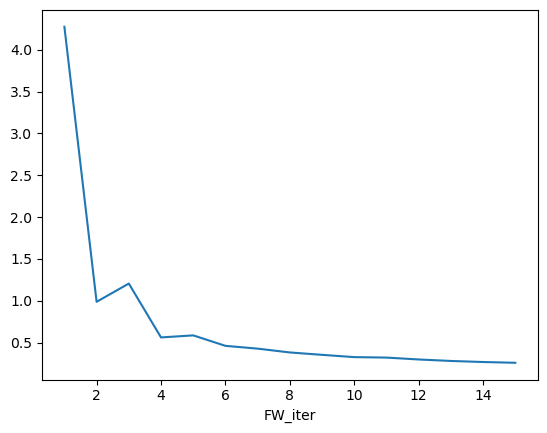

In [13]:
hist.groupby('FW_iter')['gap_FW'].mean().plot()

In [12]:
final_hist.groupby('stop_cond').size()

stop_cond
gap         841
max_iter     89
dtype: int64

In [13]:
final_hist.groupby('success')['gap_FW'].mean()

success
False    0.328365
True     0.032473
Name: gap_FW, dtype: float64

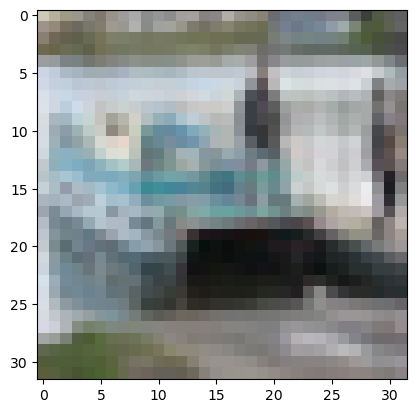

In [ ]:
plt.imshow(np.transpose(ex[3][2], (1, 2, 0)))

Mean FW iterations: 3.0086299892125137


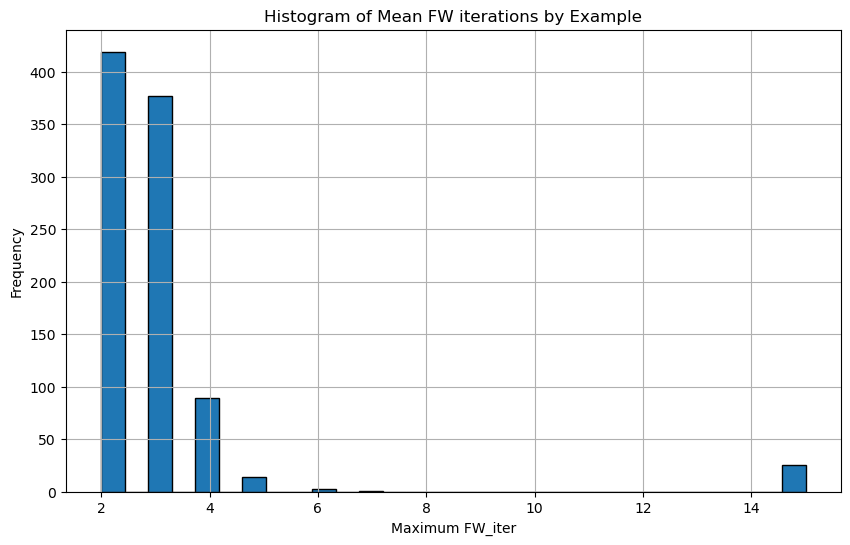

In [8]:
num_iters = hist.groupby('example_idx')['FW_iter'].max()
print(f"Mean FW iterations: {num_iters.mean()}")
plt.figure(figsize=(10, 6))
num_iters.plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of Mean FW iterations by Example')
plt.xlabel('Maximum FW_iter')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# accuracy
hist.groupby('example_idx')['first_success'].sum().mean()

0.7784946236559139

In [ ]:
# average number of iterations for success
hist[hist['first_success']]['FW_iter'].mean()

1.4820441988950277

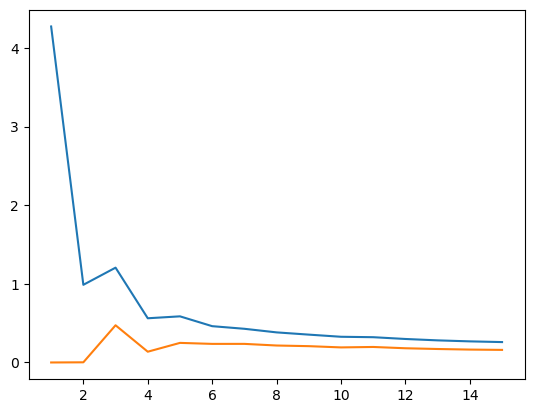

In [7]:
plt.plot(hist.groupby('FW_iter')['gap_FW'].mean())
plt.plot(hist.groupby('FW_iter')['gap_AS'].mean())

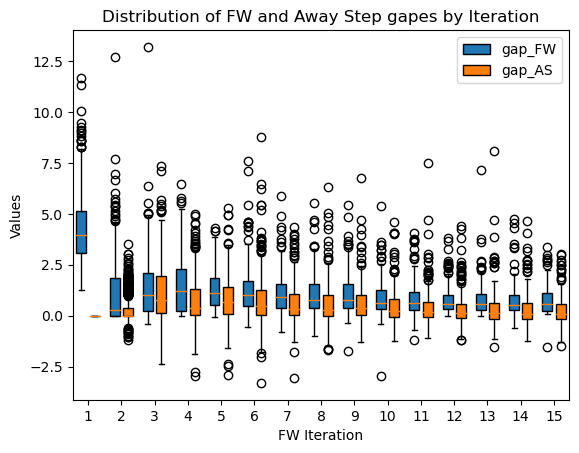

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data generation for demonstration purposes

# Extracting unique iteration groups
groups = hist['FW_iter'].unique()

# Creating lists to hold data for each group
data_FW = []
data_AS = []

for group in groups:
    data_FW.append(hist[hist['FW_iter'] == group]['gap_FW'].values)
    data_AS.append(hist[hist['FW_iter'] == group]['gap_AS'].values)

# Plotting
fig, ax = plt.subplots()

# Positions of the boxplots
positions_FW = np.arange(1, len(groups) + 1) * 2.0 - 0.4
positions_AS = np.arange(1, len(groups) + 1) * 2.0 + 0.4

# Creating the boxplots
box_FW = ax.boxplot(data_FW, positions=positions_FW, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C0"))
box_AS = ax.boxplot(data_AS, positions=positions_AS, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C1"))

# Customizing the plot
ax.set_xlabel('FW Iteration')
ax.set_ylabel('Values')
ax.set_title('Distribution of FW and Away Step gapes by Iteration')
ax.set_xticks(np.arange(1, len(groups) + 1) * 2.0)
ax.set_xticklabels([i for i in groups])

# Adding legend
ax.legend([box_FW["boxes"][0], box_AS["boxes"][0]], ['gap_FW', 'gap_AS'], loc='upper right')

# Display the plot
plt.show()


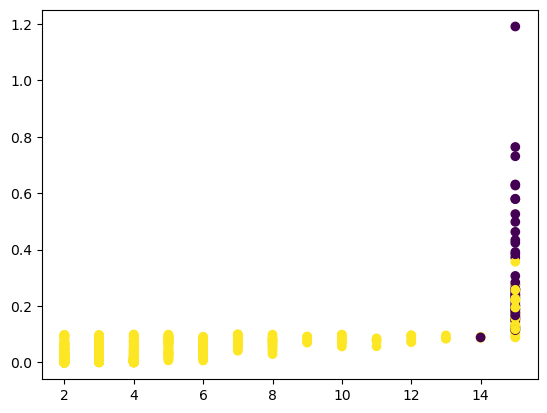

In [15]:
plt.scatter(final_hist['FW_iter'],final_hist['gap_FW'], c=final_hist['success'])

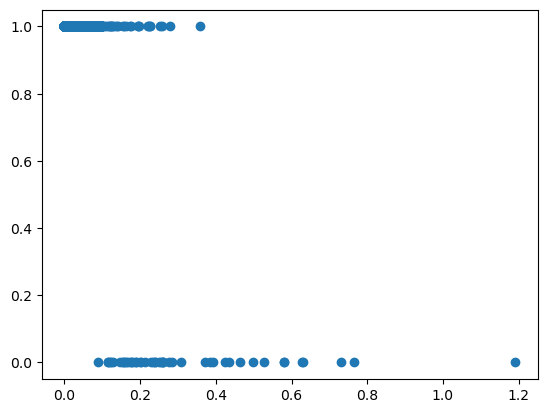

In [16]:
plt.scatter(final_hist['gap_FW'], final_hist['success'])

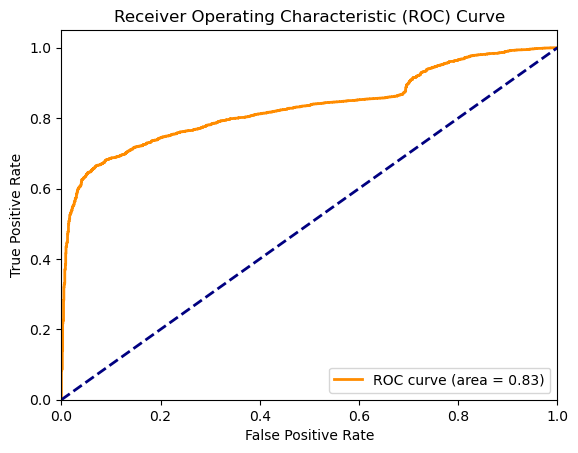

In [ ]:
from sklearn.metrics import roc_curve, auc

# Sample data: true binary labels and predicted probabilities
y_true = hist['success']
y_scores = 1- hist['gap_trans']

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

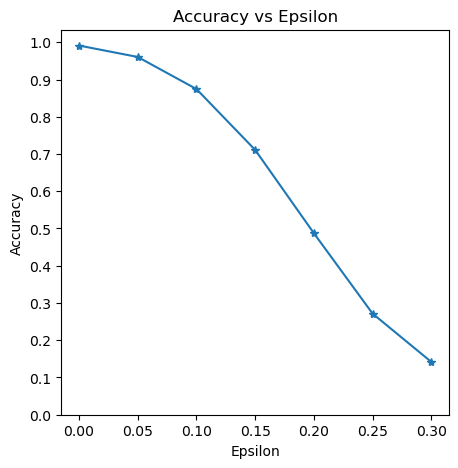

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

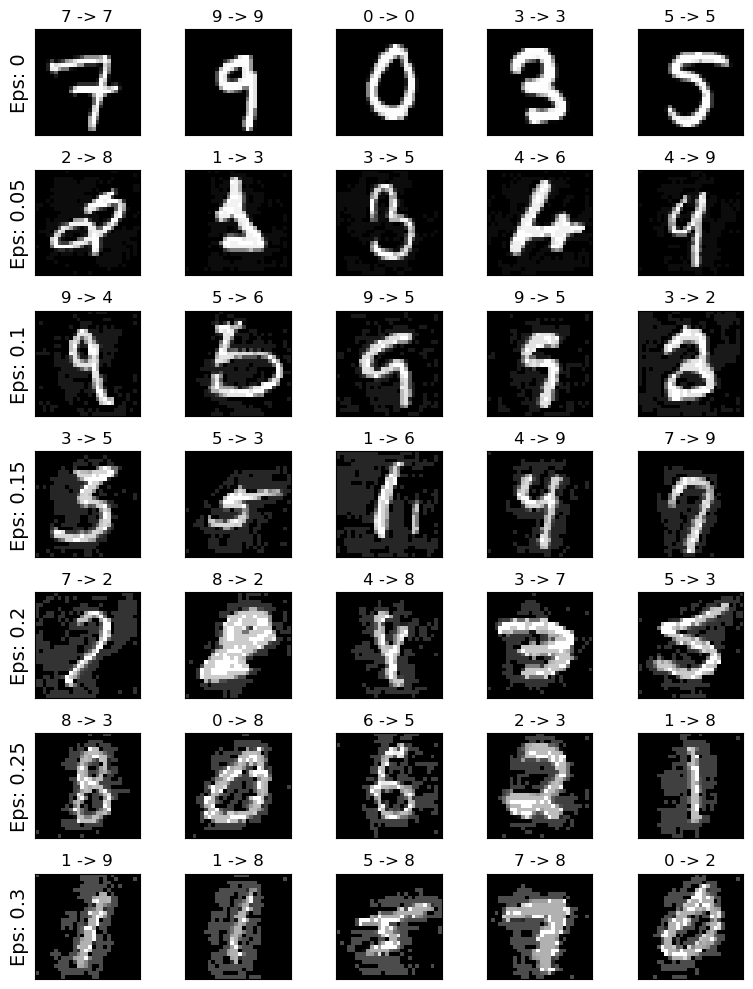

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()